In [ ]:
import requests, sys
from pathlib import Path
sys.path.append(str(Path('main_prep.ipynb').resolve().parents[1]))
from prep.params import SQLITE_PATH
from prep.sqlitedb import SQLStore

db = SQLStore(SQLITE_PATH)

db.create_video_table()
db.create_frame_table()

db.get_table_names()

Table 'Video' dropped.
Table 'Frame' dropped.
Tables 'Video' created or already exist.
Tables 'Frame' created or already exist.


['Video', 'Frame']

### Get Videos from Folder and save to SQL

In [2]:
from base import DataDirectory, Video
video_path = '../data/sample/'
Data_dir = DataDirectory(video_path)

found_videos = Data_dir.search_videos()

print(f"Found {len(found_videos)} videos in '{video_path}':")
print(found_videos[:5])

Video_list = [Video(video) for video in found_videos]


Found 3 videos in '../data/sample/':
['../data/sample/vtv24-1.mp4', '../data/sample/vtv24-3.mp4', '../data/sample/vtv24-2.mp4']


In [3]:
# Insert video metadata into the database
for video in Video_list:
    video_data = (
        video.id,
        video.path,
        video.name,
        video.metadata['size'],
        video.metadata['size_mb'],
        video.metadata['format'],
        video.metadata['last_modified'],
        video.metadata['creation_time'],
    )
    db.insert_video(video_data)

In [4]:
import pandas as pd
videos = db.fetch_videos()
db.close()
df_videos = pd.DataFrame(videos, columns=['id', 'path', 'name', 'size', 'size_mb', 'format', 'last_modified', 'creation_time', 'processed'])
df_videos.head()

Closing database connection.


,id,path,name,size,size_mb,format,last_modified,creation_time,processed
0,d138b35c-0de9-47f5-9a32-695d6028154b,../data/sample/vtv24-1.mp4,vtv24-1.mp4,5387705,5.14,.mp4,2025-06-30 23:15:41,2025-07-14 21:05:01,0
1,83cdca21-2bda-42e2-b335-449cafab563d,../data/sample/vtv24-3.mp4,vtv24-3.mp4,7378714,7.04,.mp4,2025-07-14 21:07:10,2025-07-14 21:07:32,0
2,ad9320ff-fffe-46f4-83fd-7bf5e8702340,../data/sample/vtv24-2.mp4,vtv24-2.mp4,4552985,4.34,.mp4,2025-07-14 21:03:08,2025-07-14 21:07:32,0


### Process single Video and save Images to Frame

#### 1. Frame Extraction/Detection

In [ ]:
from prep.params import SQLITE_PATH
from prep.sqlitedb import SQLStore
from prep.imageProcessing.FrameDetection.FrameDetect import FrameExtractor
from base import Frame

db = SQLStore(SQLITE_PATH)
if db.check_table_exists("Video"):
    video_ids = [video[0] for video in db.fetch_videos()]
    print(f"There are {len(video_ids)} videos in the database, ids as below:")
    print(video_ids)
    
all_frames = []

for video_id in video_ids:
    print(f"Processing video ID: {video_id}")
    video_path = db.fetch_video_by_id(video_id)[1]

    FrameExtr = FrameExtractor(video_path, video_id)
    FrameExtr.get_frames()
    for frame in FrameExtr.frames[:10]:
        print(f"Frame ID: {frame.id}, Timestamp: {frame.timestamp}, Base64 Length: {len(frame.bs64)}")

    for i, frame in enumerate(FrameExtr.frames):
        if i % 200 == 0:
            print(f"Processing frame {i+1}/{len(FrameExtr.frames)} for video ID: {video_id}")
        db.insert_frame((frame.id, frame.video_id, frame.frame_index, frame.timestamp, frame.bs64, 0))
        all_frames.append(frame)


There are 3 videos in the database, ids as below:
['d138b35c-0de9-47f5-9a32-695d6028154b', '83cdca21-2bda-42e2-b335-449cafab563d', 'ad9320ff-fffe-46f4-83fd-7bf5e8702340']
Processing video ID: d138b35c-0de9-47f5-9a32-695d6028154b
[TransNetV2] Using weights from /Users/dna-tuananguyen/Downloads/Exploring/HCMAI25/PixeFlow/data/models/TransNetV2/inference/transnetv2-weights/.
[TransNetV2] Extracting frames from ../data/sample/vtv24-1.mp4
[TransNetV2] Processing video frames 2754/2754
Frame ID: 21c51a74-766b-4a92-8fde-28aa8437cf23, Timestamp: 0.48, Base64 Length: 33160
Frame ID: 2efaefb8-39e3-49dc-9b58-4c6b65035584, Timestamp: 1.92, Base64 Length: 34204
Frame ID: 9b8f2f16-14b6-499f-a3ae-d85be8fab7a0, Timestamp: 3.08, Base64 Length: 42084
Frame ID: d483023b-1b21-4a4b-b35c-1805b411ea3c, Timestamp: 5.12, Base64 Length: 43140
Frame ID: 85e6c126-8dd9-43b3-b853-1e115d313340, Timestamp: 6.28, Base64 Length: 31528
Frame ID: 5d8f0884-0907-46ea-9935-267fc3f2aa3a, Timestamp: 7.6, Base64 Length: 29632


In [8]:
# Get all frames from the database
frames = db.fetch_frames()
db.close()
df_frames = pd.DataFrame(frames, columns=['id', 'video_id', 'frame_index', 'timestamp', 'bs64', 'processed'])
df_frames.head()

Closing database connection.


,id,video_id,frame_index,timestamp,bs64,processed
0,21c51a74-766b-4a92-8fde-28aa8437cf23,d138b35c-0de9-47f5-9a32-695d6028154b,12,0.48,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
1,2efaefb8-39e3-49dc-9b58-4c6b65035584,d138b35c-0de9-47f5-9a32-695d6028154b,48,1.92,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
2,9b8f2f16-14b6-499f-a3ae-d85be8fab7a0,d138b35c-0de9-47f5-9a32-695d6028154b,77,3.08,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
3,d483023b-1b21-4a4b-b35c-1805b411ea3c,d138b35c-0de9-47f5-9a32-695d6028154b,128,5.12,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
4,85e6c126-8dd9-43b3-b853-1e115d313340,d138b35c-0de9-47f5-9a32-695d6028154b,157,6.28,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0


In [9]:
len(df_frames)

156

#### Additional Extractions

In [ ]:
from prep.imageProcessing.FrameEmbedding.FrameEmb import ClipEncoder
from prep.imageProcessing.FrameCaptioning.FrameCap import BlipCaptioner
from prep.imageProcessing.ObjectDetection.ObjDetect import ObjectDetector
from prep.params import BLIP_DIR, CO_DETR_DIR, CLIP_DIR


image_base64_list = [frame.bs64 for frame in all_frames] # Get from SQL database

Cap = BlipCaptioner(BLIP_DIR)
Detector = ObjectDetector(CO_DETR_DIR)
Encoder = ClipEncoder(CLIP_DIR)

# Captioning, Object Detection and Embedding for each frame
for i, image_base64 in enumerate(image_base64_list):
    caption = Cap.caption(image_base64)
    objects = Detector.detect(image_base64)
    embeddings = Encoder.image_encode(image_base64)
    
    all_frames[i].embeddings = embeddings
    all_frames[i].objects = objects
    all_frames[i].caption = caption

#### Save to Vector Database

In [ ]:
from prep.vectordb import QdrantStore
from prep.params import VECTORDB_PATH, COLECTION_NAME, VECTOR_SIZES
from dotenv import load_dotenv
import os

load_dotenv()
QDRANT_CLOUD_URL = os.getenv("QDRANT_CLOUD_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

mode = "cloud"
vector_db = QdrantStore(
    collection_name=COLECTION_NAME,
    vector_sizes=VECTOR_SIZES,
    mode=mode,
    url=QDRANT_CLOUD_URL,
    api_key=QDRANT_API_KEY
)

for frame in all_frames:
    vector_db.upsert(frame)

#### 2. Frame Captioning

In [ ]:
import requests, sys
from PIL import Image
from pathlib import Path
sys.path.append(str(Path('main_prep.ipynb').resolve().parents[1]))

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Image to base64
import base64
from io import BytesIO
def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

image_base64 = image_to_base64(image)

/Users/dna-tuananguyen/anaconda3/envs/apitcdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Generated Caption: 
 a couple of cats sleeping on top of each other


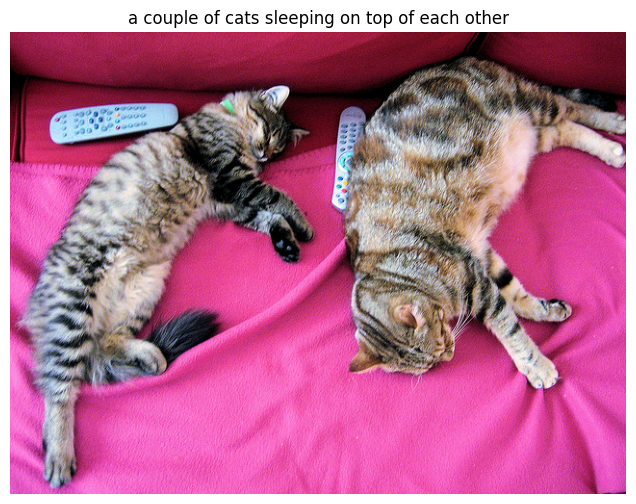

In [ ]:
from prep.imageProcessing.FrameCaptioning.FrameCap import BlipCaptioner
from prep.params import BLIP_DIR
Cap = BlipCaptioner(blip_dir=BLIP_DIR)

image_base64 = ... # Get from SQL database
caption = Cap.caption(image_base64)
print("\nGenerated Caption: \n", caption)

# Display the image with the caption in notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()

#### 3. Frame Object Detection

In [ ]:
from prep.imageProcessing.ObjectDetection.ObjDetect import ObjectDetector
from prep.params import CO_DETR_DIR

detector = ObjectDetector(CO_DETR_DIR)
results = detector.detect(image_base64)
# print(results)
# detector.visualize(image_base64)

{'boxes': [[343.1755065917969, 24.767948150634766, 640.4005126953125, 373.996826171875], [327.0817565917969, 75.79769897460938, 372.8892517089844, 188.01234436035156], [38.136959075927734, 69.69452667236328, 176.1708221435547, 119.78018188476562], [15.481481552124023, 51.99665832519531, 315.6678771972656, 470.614501953125], [-0.20952224731445312, 0.6423282623291016, 639.7437133789062, 474.6432800292969]], 'scores': [0.9985529780387878, 0.9981963038444519, 0.9942688941955566, 0.997520387172699, 0.9922892451286316], 'labels': ['cat', 'remote', 'remote', 'cat', 'couch']}


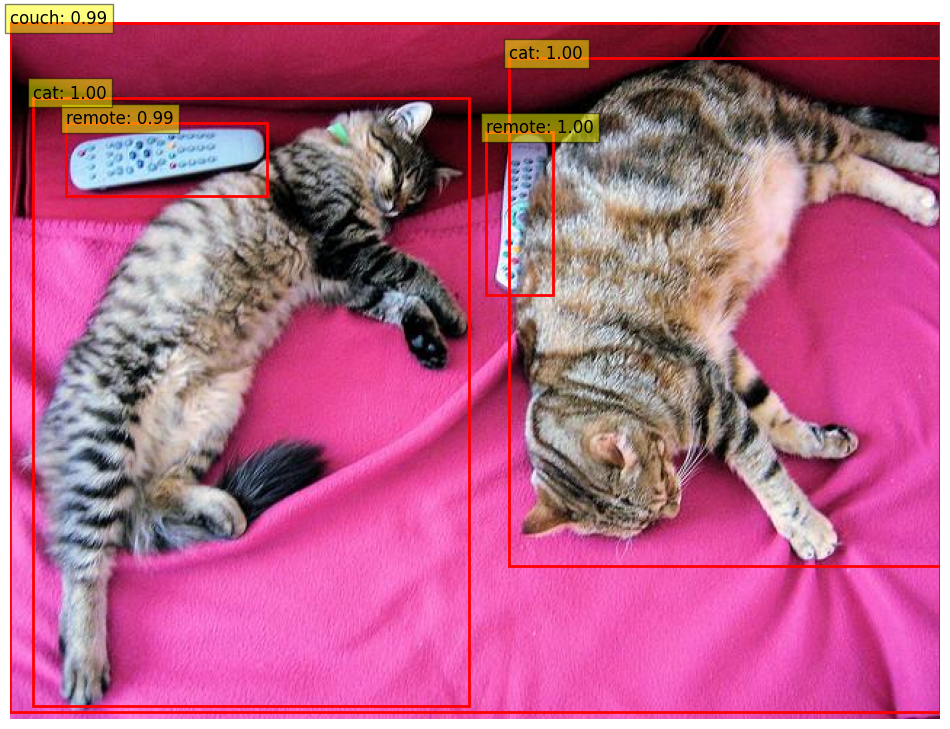

#### 4. Frame Embeddings

In [ ]:
from prep.imageProcessing.FrameEmbedding.FrameEmb import ClipEncoder
from prep.params import CLIP_DIR
encoder = ClipEncoder(CLIP_DIR)

caption = "Two cats lying on a couch."
embeddings = encoder.text_encode(caption)
print("Caption:", caption)
print("Caption Embeddings:", embeddings[:30])

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Caption: Two cats lying on a couch.
Caption Embeddings: [ 0.361555    0.00314771 -0.73712516 -0.32338864 -0.07349119  0.37436077
 -0.21132943 -0.33249035 -0.41861153 -0.13717073 -0.05834646 -0.07563007
 -0.00573006 -0.26364675 -0.33415237  0.35076338 -0.28190213 -0.18699846
 -0.09906087  0.75754476 -0.09495345 -0.1655966  -0.01630946  0.0591142
  0.26926294  0.06757624 -0.18240401  0.57804084 -0.09547476 -0.04374057]


In [ ]:
img_embeddings = encoder.image_encode(image_base64)
print("Image Embeddings:", img_embeddings[:30])

Image Embeddings: [-0.08948638  0.15628737 -0.35676813 -0.19910409 -0.05353561 -0.23494473
 -0.36256215  0.13674879  0.245684    0.01422149  0.01345567 -0.33739328
 -0.16180873 -0.08207195 -0.3717878  -0.06883799  0.0195387  -0.3153079
  0.1567308   0.4507324  -1.1208708   0.05919155  0.44203115 -0.15207525
  0.0087807   0.22118488  0.3020258  -0.01113755  0.16244492  0.06588645]
